# purpose of this notebook
1. split runs with "trigger event" 
    - e.g. binarize the values and identify start stop indices
2. extract ttl onsets
    - convert each event into trial number
    - do this based on two events: expect and actual

# TODO:
- [ ] identify BIDS scheme for physio data 
- [ ] flag files without ANISO
- [ ] flag files with less than 5 runs
- [ ] for those runs, we need to manually assign run numbers (biopac will collect back to back)
- [ ] change main_dir directory when running on discovery
- [ ] create metadata, of folders and how columns were calculated 
- [ ] remove unnecessary print statements
# 

estimated run time: 398.76

In [1]:
import neurokit2 as nk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import os, glob, shutil, datetime
from pathlib import Path
import json

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 9]  # Bigger images

functions

In [15]:
def binarize_channel(data, origin_col, new_col, threshold, binary_h, binary_l):
    """
    data: pandas dataframe. acquisition file
    origin_col: columns with raw signal
    new_col: new columns for saving binarized origin_col values in
    threshold: int. threshold for binarizing values within pandas column
    binary_h, binary_l: two numbers. e.g. 5, 0 or 1, 0

    """
    data.loc[data[origin_col] > threshold, new_col] = binary_h
    data.loc[data[origin_col] <= threshold, new_col] = binary_l



In [3]:
# %% directories ___________________________________
# current_dir = os.getcwd()
# main_dir = Path(current_dir).parents[1]

# %% temporary
main_dir = '/Volumes/spacetop'
print(main_dir)
save_dir = os.path.join(main_dir, 'biopac', 'dartmouth', 'b03_extract_ttl')
print(save_dir)

/Volumes/spacetop
/Volumes/spacetop/biopac/dartmouth/b03_extract_ttl


In [8]:
acq_list = glob.glob(os.path.join(main_dir, 'biopac', 'dartmouth', 'b02_sorted', 'sub-' + ('[0-9]' * 4), '*', '*task-social*_physio.acq'), recursive = True)
flaglist = []

In [59]:
# extract info
acq = acq_list[3]
filename  = os.path.basename(acq)
sub = [match for match in filename.split('_') if "sub" in match][0]
ses = [match for match in filename.split('_') if "ses" in match][0] # 'ses-03'
task = [match for match in filename.split('_') if "task" in match][0]

In [60]:
print(sub, ses, task)

sub-0050 ses-04 task-social


# Previous code 
* run transitions were detected based on the Trigger channel.
* was not able to handle runs that started before an MR scanner. 
* See plot below. Note that this dataframe has a signal in the beginning.
* Previous code would treat this as the beginning of the experiment and break the code.

Text(0.5, 1.0, 'plot signals from fMRI Aniso trigger. Also plot channel TRIGGER. ')

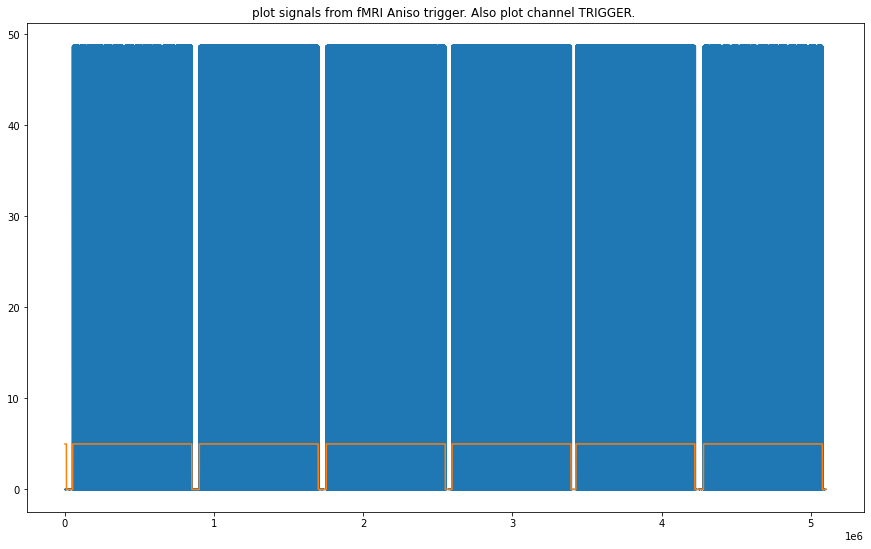

In [11]:
spacetop_data, spacetop_samplingrate = nk.read_acqknowledge(acq)
plt.plot(spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'])
plt.plot(spacetop_data['trigger'])
plt.title("plot signals from fMRI Aniso trigger. Also plot channel TRIGGER. ")

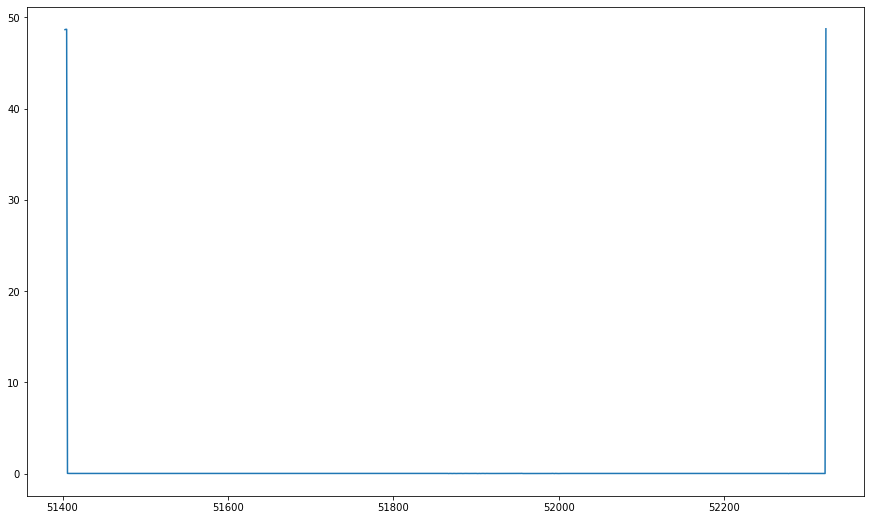

In [12]:
plt.plot(spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'][51403:51403+460*2+1])

# What needs to be done
* Signals directly from Channel :: **fMRI Trigger - CBLCFMA - Current Feedba** should be the golden standard
* We'll use Pandas rolling window function to downsample transitions
* afterwards, I identify the min, max signals in the corresponding channel and binarize the signals if above/below the mid value of total signals

In [61]:
spacetop_data['mr_trigger'] = spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'].rolling(window=460*2).mean()
spacetop_data['mr_trigger']
mid_val = (np.max(spacetop_data['mr_trigger']) - np.min(spacetop_data['mr_trigger']))/2
print(mid_val)
binarize_channel(spacetop_data,
                    origin_col='mr_trigger',
                    new_col='mr_aniso',
                    threshold=mid_val,
                    binary_h=5,
                binary_l=0)
start_df = spacetop_data[spacetop_data['mr_aniso'] > spacetop_data['mr_aniso'].shift(1)].index
stop_df = spacetop_data[spacetop_data['mr_aniso'] < spacetop_data['mr_aniso'].shift(1)].index
print(start_df)
print(stop_df)

0.10717640752377718
Int64Index([51404, 899340, 1750768, 2593712, 3425265, 4279821], dtype='int64')
Int64Index([852720, 1701576, 2553004, 3395949, 4227501, 5082057], dtype='int64')


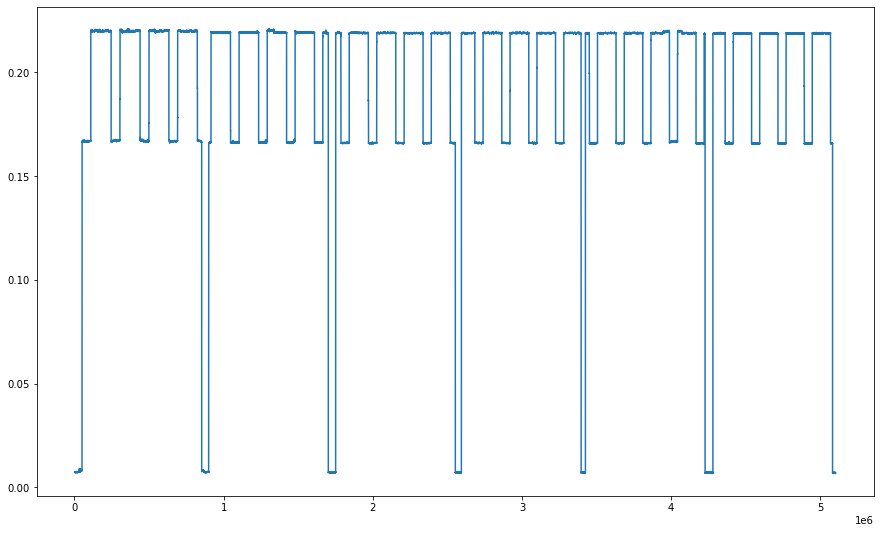

In [18]:
plt.plot(spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'].rolling(window=460*2).mean())

# TADA! we now have a clean run transition, based on the fMRI aniso trigger channel

Text(0.5, 1.0, 'identify transitions')

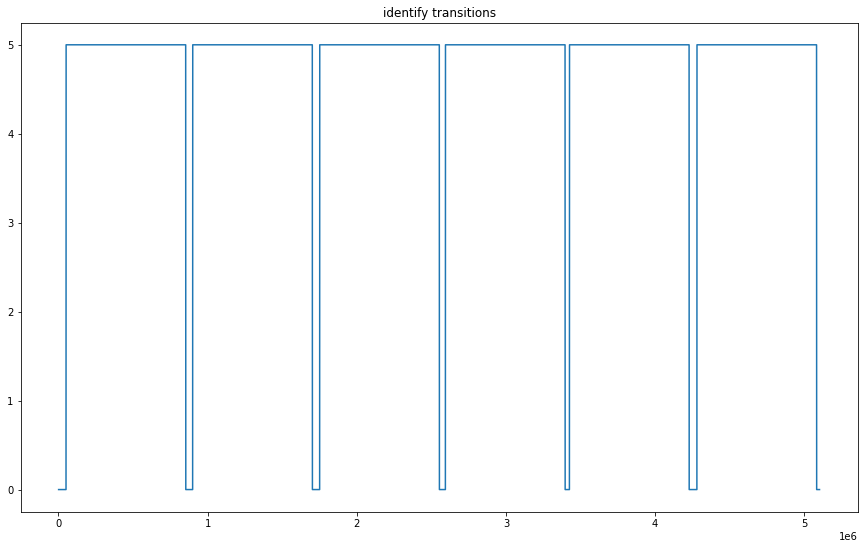

In [19]:
plt.plot(spacetop_data['mr_aniso'])
# plt.plot(spacetop_data['trigger'])
plt.title("identify transitions")

In [20]:
spacetop_data['mr_trigger'] = spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'].rolling(window=460*2).mean()
# %% EV trigger :: identify transitions based on "trigger" ev 
mid_val = (np.max(spacetop_data['mr_trigger']) -
            np.min(spacetop_data['mr_trigger'])) / 2
binarize_channel(spacetop_data,
                    origin_col='mr_trigger',
                    new_col='mr_aniso',
                    threshold=mid_val,
                    binary_h=5,
                    binary_l=0)
start_df = spacetop_data[spacetop_data['mr_aniso'] > spacetop_data['mr_aniso'].shift(1)].index
stop_df = spacetop_data[spacetop_data['mr_aniso'] < spacetop_data['mr_aniso'].shift(1)].index

# %% EV TTL :: identify ttl events based on TTL column
spacetop_data['TTL'] = spacetop_data[
    'TSA2 TTL - CBLCFMA - Current Feedback M'].rolling(
        window=2000).mean()
binarize_channel(spacetop_data,
                    origin_col='TTL',
                    new_col='ttl_aniso',
                    threshold=5,
                    binary_h=5,
                    binary_l=0)
# %% EV stimuli :: 
mid_val = (np.max(spacetop_data['administer']) - np.min(spacetop_data['administer']))/2
binarize_channel(spacetop_data,
            origin_col='administer',
            new_col='stimuli',
            threshold=mid_val,
            binary_h=5,
            binary_l=0)

df_transition = pd.DataFrame({
                'start_df': start_df, 
                'stop_df': stop_df
                })

for r in range(len(start_df)):
    if (stop_df[r] - start_df[r]) / 2000 < 300:
        spacetop_data.drop(spacetop_data.index[start_df[r]:stop_df[r]],
                            axis=0,
                            inplace=True)
        start_df.pop(r)
        stop_df.pop(r)
# identify runs with TTL signal
ttl_bool = []
for r in range(len(start_df)):
    bool_val = np.unique(spacetop_data.iloc[df_transition.start_df[r]:df_transition.stop_df[r],spacetop_data.columns.get_loc('ttl_aniso')]).any()
    ttl_bool.append(bool_val)

acq_runs_with_ttl = [i for i, x in enumerate(ttl_bool) if x]
print(f"acq_runs_with_ttl: {acq_runs_with_ttl}")


acq_runs_with_ttl: [1, 4]


In [51]:
start_df
# stop_df

Int64Index([50484, 899340, 1750768, 2593712, 3425265, 4279821], dtype='int64')

Text(0.5, 1.0, 'blue is fMRI aniso trigger. Orange is when the experiment starts with first trigger\n note that we need to discard the first trigger - it is not deetected by the experiment')

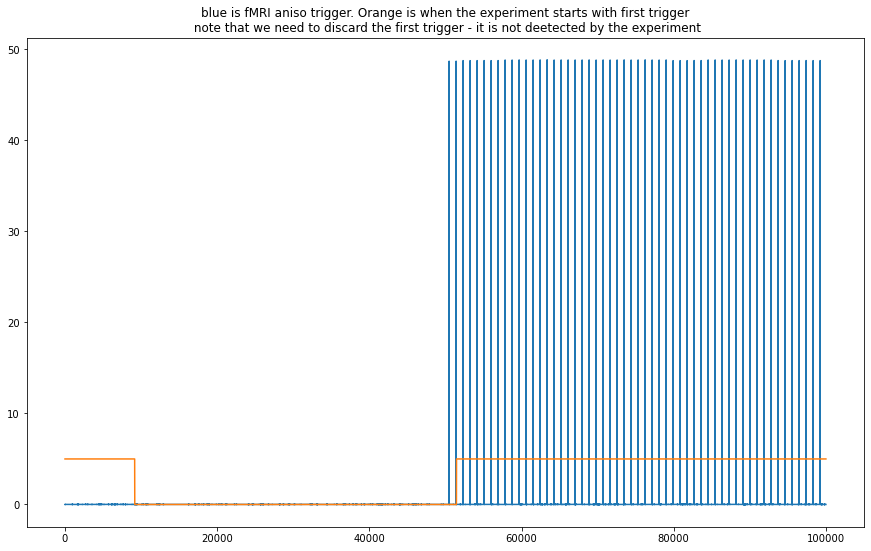

In [50]:
# plt.plot(spacetop_data['mr_aniso'][0:200000])
plt.plot(spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'][0:100000])
plt.plot(spacetop_data['trigger'][0:100000])
plt.title('blue is fMRI aniso trigger. Orange is when the experiment starts with first trigger\n note that we need to discard the first trigger - it is not deetected by the experiment')

In [66]:
spacetop_data['mr_trigger'] = spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'].rolling(window=460*2).mean()
# %% EV trigger :: identify transitions based on "trigger" ev 
mid_val = (np.max(spacetop_data['mr_trigger']) -
            np.min(spacetop_data['mr_trigger'])) / 2
binarize_channel(spacetop_data,
                    origin_col='mr_trigger',
                    new_col='mr_aniso',
                    threshold=mid_val,
                    binary_h=5,
                    binary_l=0)
start_df = spacetop_data[spacetop_data['mr_aniso'] > spacetop_data['mr_aniso'].shift(1)].index
stop_df = spacetop_data[spacetop_data['mr_aniso'] < spacetop_data['mr_aniso'].shift(1)].index
print(start_df)
sdf= spacetop_data.copy()
sdf.loc[start_df[0]-2:start_df[0]+2, 'fMRI Trigger - CBLCFMA - Current Feedba'] = 0

Int64Index([51404, 899340, 1750768, 2593712, 3425265, 4279821], dtype='int64')


In [71]:
sdf['mr_trigger'] = sdf['fMRI Trigger - CBLCFMA - Current Feedba'].rolling(window=460*2).mean()
mid_val = (np.max(sdf['mr_trigger']) -
            np.min(sdf['mr_trigger'])) / 2
binarize_channel(sdf,
                    origin_col='mr_trigger',
                    new_col='mr_aniso',
                    threshold=mid_val,
                    binary_h=5,
                    binary_l=0)
nstart_df = sdf[sdf['mr_aniso'] > sdf['mr_aniso'].shift(1)].index
nstop_df = sdf[sdf['mr_aniso'] < sdf['mr_aniso'].shift(1)].index
print(nstart_df)
print(nstop_df)

Int64Index([52324, 899340, 1750768, 2593712, 3425265, 4279821], dtype='int64')
Int64Index([852720, 1701576, 2553004, 3395949, 4227501, 5082057], dtype='int64')


52323    48.742676
52324    48.748779
52325    48.739624
53243    48.730469
53244    48.745728
53245    48.742676
54163    48.739624
54164    48.739624
54165    48.748779
Name: fMRI Trigger - CBLCFMA - Current Feedba, dtype: float64

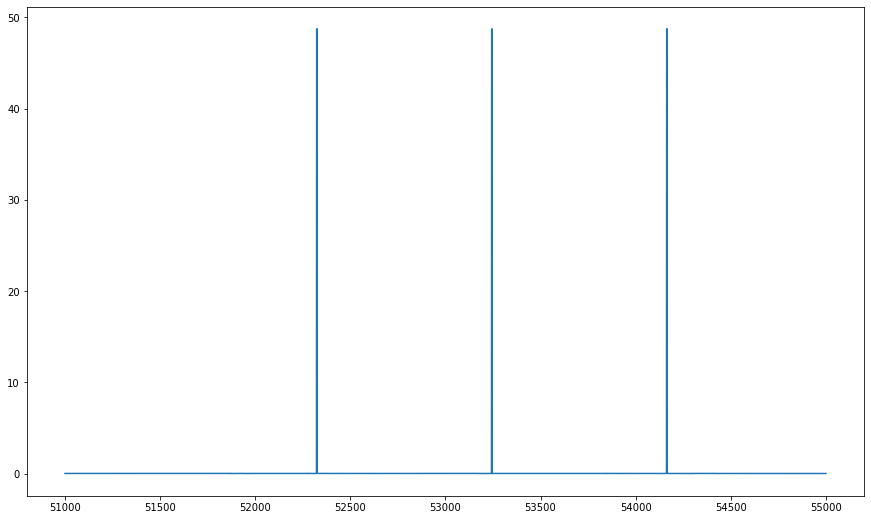

In [84]:
plt.plot(sdf.loc[51000:55000, 'fMRI Trigger - CBLCFMA - Current Feedba'])
subset = sdf.loc[51000:55000, 'fMRI Trigger - CBLCFMA - Current Feedba']
subset[subset> 40]

# Note that TTL transisions are not as clear
* we notice a blue spike in the last run
* The last run is not a pain run
* However, we may have gotten that spike because we turned the TSA2 off during that last run
* Let's remove that odd blue spike. 

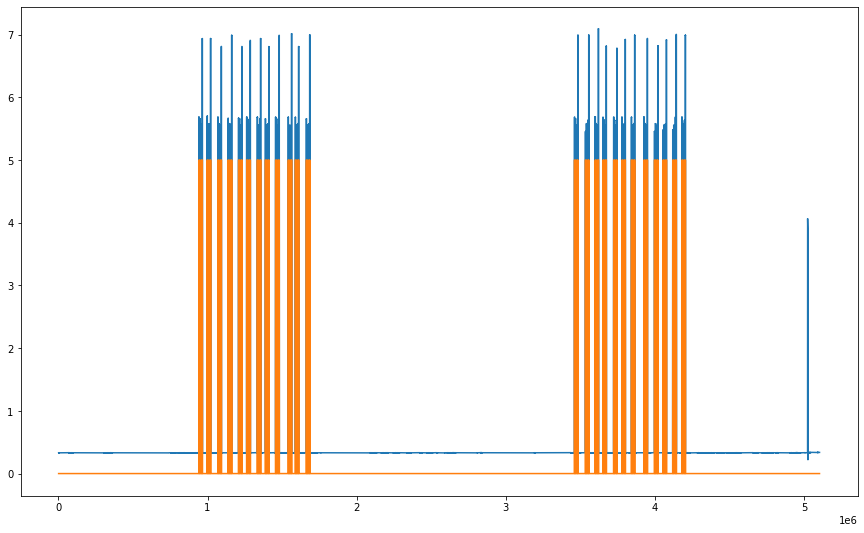

In [23]:
plt.plot(spacetop_data['TSA2 TTL - CBLCFMA - Current Feedback M'].rolling(window=2000).mean())
spacetop_data['TTL'] = spacetop_data['TSA2 TTL - CBLCFMA - Current Feedback M'].rolling(window=2000).mean()
spacetop_data.loc[spacetop_data['TTL'] > 5, 'ttl_aniso'] = 5
spacetop_data.loc[spacetop_data['TTL'] <= 5, 'ttl_aniso'] = 0
plt.plot(spacetop_data['ttl_aniso'])

* Now we're removed the odd blue spike, reflected in the green bars
* We did this by identifying a rollowing window and binarizing signals based on a threshold of 5 (which is the recorded signal for a TTL from Medoc)

Text(0.5, 1.0, 'identify transitions')

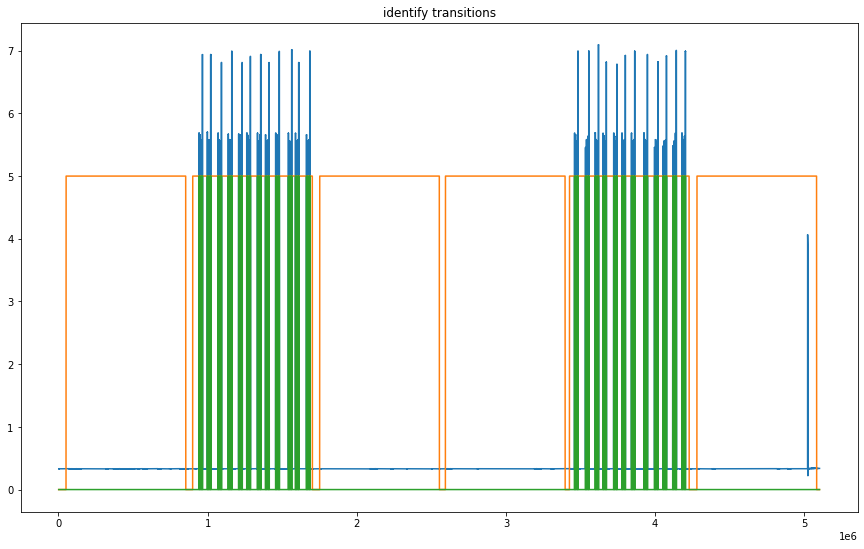

In [24]:
plt.plot(spacetop_data['TTL'])
plt.plot(spacetop_data['mr_aniso'])
plt.plot(spacetop_data['ttl_aniso'])
plt.title("identify transitions")
# Green does not have that spike anymore

In [25]:
print(start_df)
print(stop_df)

Int64Index([50484, 899340, 1750768, 2593712, 3425265, 4279821], dtype='int64')
Int64Index([852720, 1701576, 2553004, 3395949, 4227501, 5082057], dtype='int64')


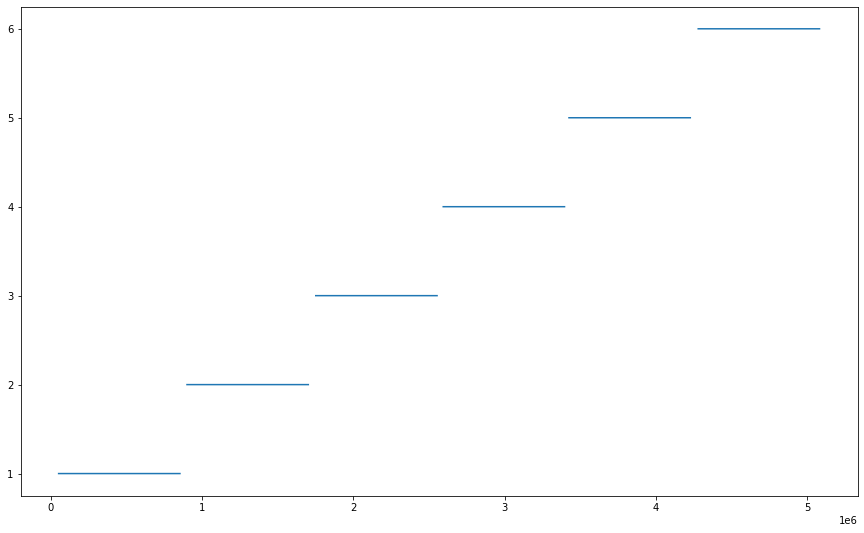

In [26]:
for r in range(len(start_df)):
    spacetop_data.at[start_df[r]:stop_df[r], 'run_num'] = r+1
plt.plot(spacetop_data.run_num)

In [109]:
(852720-50484)/2000

401.118

In [27]:
run_len = len(df_transition)
# if run_len == 6:
for i, run_num in enumerate(acq_runs_with_ttl):
    run_subset = spacetop_data.loc[spacetop_data['run_num'] == run_num+1]
    if 380 < len(run_subset)/2000 < 410:
        print(i, run_num, len(run_subset)/2000 )

0 1 401.1185
1 4 401.1185


In [1]:
len(run_subset)/2000

NameError: name 'run_subset' is not defined

In [154]:
run_subset = spacetop_data.loc[spacetop_data['run_num'] == run_num+1]
len(run_subset)/2000

401.1185

In [145]:

# %%    # FOR LOOP START _________________
run_len = len(df_transition)
if run_len == 6:
    for i, run_num in enumerate(runs_with_ttl):
        print(i, run_num)

        run = f"run-{run_num + 1:02d}"
        print(run)
        run_subset = spacetop_data.loc[spacetop_data['run_num'] == run_num+1]

        # run_subset = spacetop_data[df_transition.start_df[run_num]: df_transition.stop_df[run_num]]
        run_df = run_subset.reset_index()
        # identify events :: expect and actual _________________
        start_expect = run_df[run_df['expect'] > run_df[ 'expect'].shift(1)]
        start_actual = run_df[run_df['actual'] > run_df[ 'actual'].shift(1)]
        stop_actual= run_df[run_df['actual'] < run_df[ 'actual'].shift(1)]

        # identify events :: stimulli _________________
        start_stim = run_df[run_df['stimuli'] > run_df[ 'stimuli'].shift(1)]
        stop_stim= run_df[run_df['stimuli'] < run_df[ 'stimuli'].shift(1)]
        events = nk.events_create(event_onsets=list(start_stim.index), 
        event_durations = list((stop_stim.index-start_stim.index)/spacetop_samplingrate))

        # transform events :: transform to onset _________________
        expect_start = start_expect.index/spacetop_samplingrate
        actual_end = stop_actual.index/spacetop_samplingrate
        stim_start = start_stim.index/spacetop_samplingrate
        stim_end = stop_stim.index/spacetop_samplingrate
        stim_onset = events['onset']/spacetop_samplingrate

        # build pandas dataframe _________________
        df_onset = pd.DataFrame({
            'expect_start': expect_start, 
            'actual_end': actual_end,
            'stim_start': np.nan,
            'stim_end':np.nan
        })

        df_stim = pd.DataFrame({
            'stim_start': stim_start, 
            'stim_end': stim_end
            })

        final_df = pd.DataFrame()

0 1
run-02
1 4
run-05


In [78]:
# split runs with "trigger event" e.g. binarize the values and identify start stop indices
# ttl onsets
#   convert each event into trial number
# do this based on two events: expect and actual

# TODO:
# * identify BIDS scheme for physio data 
# * flag files without ANISO
# * flag files with less than 5 runs
# ** for those runs, we need to manually assign run numbers (biopac will collect back to back)
# * change main_dir directory when running on discovery
# TODO: create metadata, of folders and how columns were calculated 
# * remove unnecessary print statements
# 

# %% libraries ________________________
import neurokit2 as nk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import os, glob, shutil, datetime
from pathlib import Path
import json

# %% directories ___________________________________
# current_dir = os.getcwd()
# main_dir = Path(current_dir).parents[1]

# %% temporary
main_dir = '/Volumes/spacetop'
print(main_dir)
save_dir = os.path.join(main_dir, 'biopac', 'dartmouth', 'b03_extract_ttl')
print(save_dir)
# %% filename __________________________
# filename ='/Users/h/Dropbox/projects_dropbox/spacetop_biopac/data/sub-0026/SOCIAL_spacetop_sub-0026_ses-01_task-social_ANISO.acq'
acq_list = glob.glob(os.path.join(main_dir, 'biopac', 'dartmouth', 'b02_sorted', 'sub-' + ('[0-9]' * 4), '*', '*task-social*_physio.acq'), recursive = True)
flaglist = []
# %%
for acq in sorted(acq_list[1]):
    filename  = os.path.basename(acq)
    sub = [match for match in filename.split('_') if "sub" in match][0]
    ses = [match for match in filename.split('_') if "ses" in match][0] # 'ses-03'
    task = [match for match in filename.split('_') if "task" in match][0]
    try: 
        spacetop_data, spacetop_samplingrate = nk.read_acqknowledge(acq)

        # ____________________________________ identify run transitions ____________________________________
        # %% EV trigger :: identify transitions based on "fMRI Trigger - CBLCFMA - Current Feedba" ev 
        spacetop_data['mr_aniso'] = spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'].rolling(window=460*2).mean()
        mid_val = (np.max(spacetop_data['mr_aniso']) - np.min(spacetop_data['mr_aniso']))/2
        spacetop_data.loc[spacetop_data['mr_aniso'] > mid_val, 'mr_aniso'] = 5
        spacetop_data.loc[spacetop_data['mr_aniso'] <= mid_val, 'mr_aniso'] = 0
        start_df = spacetop_data[spacetop_data['mr_aniso'] > spacetop_data['mr_aniso'].shift(1)].index
        stop_df = spacetop_data[spacetop_data['mr_aniso'] < spacetop_data['mr_aniso'].shift(1)].index

        # %% EV TTL :: identify ttl events based on TTL column
        spacetop_data['TTL'] = spacetop_data['TSA2 TTL - CBLCFMA - Current Feedback M'].rolling(window=2000).mean()
        spacetop_data.loc[spacetop_data['TTL'] > 5, 'ttl_aniso'] = 5
        spacetop_data.loc[spacetop_data['TTL'] <= 5, 'ttl_aniso'] = 0

        # %% EV stimuli :: 
        mid_val = (np.max(spacetop_data['administer']) - np.min(spacetop_data['administer']))/2
        spacetop_data.loc[spacetop_data['administer'] > mid_val, 'stimuli'] = 5
        spacetop_data.loc[spacetop_data['administer'] <= mid_val, 'stimuli'] = 0

        df_transition = pd.DataFrame({
                        'start_df': start_df, 
                        'stop_df': stop_df
                        })

        # identify runs with TTL signal
        ttl_bool = [];runs_with_ttl = []
        for r in range(len(start_df)):
            bool_val = np.unique(spacetop_data.iloc[df_transition.start_df[r]:df_transition.stop_df[r],spacetop_data.columns.get_loc('ttl_aniso')]).any()
            ttl_bool.append(bool_val)

        for r in range(len(start_df)):
            spacetop_data.at[start_df[r]:stop_df[r], 'run_num'] = r+1
        runs_with_ttl = [i for i, x in enumerate(ttl_bool) if x]
        
        # TODO: if each run,greater than 395 s

        # ____________________________________ identify TTL signals and trials ____________________________________
        # run_len = len(df_transition)
        # if run_len == 6:
        if runs_with_ttl:
            print(sub, ses, task)
            print(f"runs with ttl: {runs_with_ttl}")
            for i, run_num in enumerate(runs_with_ttl):
                run_subset = spacetop_data.loc[spacetop_data['run_num'] == run_num+1]
                print(len(run_subset)/2000)
                if 300 < len(run_subset)/2000 < 450: # check if run length is around 389 s
                    print(i, run_num)
                    run = f"run-{run_num + 1:02d}"
                    print(run)
                    run_df = run_subset.reset_index()
                    # identify events :: expect and actual _________________
                    start_expect = run_df[run_df['expect'] > run_df[ 'expect'].shift(1)]
                    start_actual = run_df[run_df['actual'] > run_df[ 'actual'].shift(1)]
                    stop_actual= run_df[run_df['actual'] < run_df[ 'actual'].shift(1)]
                    # identify events :: stimulli _________________
                    start_stim = run_df[run_df['stimuli'] > run_df[ 'stimuli'].shift(1)]
                    stop_stim= run_df[run_df['stimuli'] < run_df[ 'stimuli'].shift(1)]
                    events = nk.events_create(event_onsets=list(start_stim.index), 
                    event_durations = list((stop_stim.index-start_stim.index)/spacetop_samplingrate))
                    # transform events :: transform to onset _________________
                    expect_start = start_expect.index/spacetop_samplingrate
                    actual_end = stop_actual.index/spacetop_samplingrate
                    stim_start = start_stim.index/spacetop_samplingrate
                    stim_end = stop_stim.index/spacetop_samplingrate
                    stim_onset = events['onset']/spacetop_samplingrate
                    # build pandas dataframe _________________
                    df_onset = pd.DataFrame({
                        'expect_start': expect_start, 
                        'actual_end': actual_end,
                        'stim_start': np.nan,
                        'stim_end':np.nan
                    })
                    df_stim = pd.DataFrame({
                        'stim_start': stim_start, 
                        'stim_end': stim_end
                        })

                    final_df = pd.DataFrame()
                    
                    # events :: stimuli
                    # for loop, identify the order of "stimulus events" 
                    # based on information of "expect, actual" events, we will assign a trial number to stimulus events
                    # RESOURCE: https://stackoverflow.com/questions/62300474/filter-all-rows-in-a-pandas-dataframe-where-a-given-value-is-between-two-columnv
                    for i in range(len(df_stim)):
                        idx = pd.IntervalIndex.from_arrays(
                            df_onset['expect_start'], df_onset['actual_end'])
                        start_val = df_stim.iloc[i][df_stim.columns.get_loc('stim_start')]
                        interval_idx = df_onset[idx.contains(start_val)].index[0]
                        df_onset.iloc[interval_idx, df_onset.columns.get_loc('stim_start')] = start_val
                        end_val = df_stim.iloc[i][df_stim.columns.get_loc('stim_end')]
                        interval_idx = df_onset[idx.contains(end_val)].index[0]
                        df_onset.iloc[interval_idx, df_onset.columns.get_loc('stim_end')] = end_val
                        print(f"this is the {i}-th iteration. stim value is {start_val}, and is in between index {interval_idx}")
                    # identify events :: TTL _________________
                    # calculate TTL onsets
                    start_ttl = run_df[run_df['TTL'] > run_df[ 'TTL'].shift(1)]
                    stop_ttl = run_df[run_df['TTL'] < run_df[ 'TTL'].shift(1)]
                    ttl_onsets =   list(start_ttl.index + (stop_ttl.index-start_ttl.index)/2)/spacetop_samplingrate
                    print(f"ttl onsets: {ttl_onsets}, length of ttl onset is : {len(ttl_onsets)}")
                    # define empty TTL data frame
                    df_ttl = pd.DataFrame(np.nan, 
                                        index=np.arange(len(df_onset)),
                                        columns= ['ttl_1', 'ttl_2','ttl_3', 'ttl_4'])
                    # identify which set of TTLs fall between expect and actual 
                    pad = 1 # seconds. you may increase the value to have a bigger event search interval
                    df_onset['expect_start_interval'] = df_onset['expect_start']-pad
                    df_onset['actual_end_interval'] = df_onset['actual_end']+pad
                    idx = pd.IntervalIndex.from_arrays(
                                df_onset['expect_start_interval'], df_onset['actual_end_interval'])
                    for i in range(len(ttl_onsets)):
                        val = ttl_onsets[i]
                        print(f"{i}-th value: {val}")
                        empty_cols = []
                        interval_idx = df_onset[idx.contains(val)].index[0]
                        print(f"\t\t* interval index: {interval_idx}")
                        mask = df_ttl.loc[[interval_idx]].isnull()
                        empty_cols = list(itertools.compress(np.array(df_ttl.columns.to_list()), mask.values[0]))
                        print(f"\t\t* empty columns: {empty_cols}")
                        df_ttl.loc[df_ttl.index[interval_idx], str(empty_cols[0])] = val
                        print(f"\t\t* this is the row where the value -- {val} -- falls. on the {interval_idx}-th row")
                    # merge :: merge df_onset and df_ttl -> final output: final_df
                    final_df = pd.merge(df_onset, df_ttl, left_index=True, right_index=True)
                    final_df['ttl_r1'] = final_df['ttl_1'] - final_df['stim_start']
                    final_df['ttl_r2'] = final_df['ttl_2'] - final_df['stim_start']
                    final_df['ttl_r3'] = final_df['ttl_3'] - final_df['stim_start']
                    final_df['ttl_r4'] = final_df['ttl_4'] - final_df['stim_start']
                    # save output as
                    save_filename = f"{sub}_{ses}_{task}_{run}_physio-ttl.csv"
                    new_dir = os.path.join(save_dir, task, sub, ses)
                    print(new_dir)
                    Path(new_dir).mkdir( parents=True, exist_ok=True )
                    final_df.reset_index(inplace=True)
                    final_df = final_df.rename(columns = {'index':'trial_num'})
                    final_df.to_csv(os.path.join(new_dir, save_filename), index=False)
                else:
                    flaglist.append('\nrun length is shorter than 380s or longer than 410s')
                    flaglist.append(acq_list)
        else:
            print("no ttl runs")
    except:
        flaglist.append('\nfailed')
        flaglist.append(acq_list)

# txt_filename = os.path.join(save_dir, f'biopac_flaglist_{datetime.date.today().isoformat()}.txt')
# with open(txt_filename, 'w') as f:
#     f.write(json.dumps(flaglist))
# # txt_filename = os.path.join(/scripts/flags', f'biopac_flaglist_{datetime.date.today().isoformat()}.txt')
# # with open(txt_filename, 'w') as f:
# #     f.write(json.dumps(flaglist))



/Volumes/spacetop
/Volumes/spacetop/biopac/dartmouth/b03_extract_ttl


IndexError: list index out of range

In [79]:
acq = acq_list[1]

In [80]:
acq

'/Volumes/spacetop/biopac/dartmouth/b02_sorted/sub-0050/ses-03/sub-0050_ses-03_task-social_recording-ppg-eda_physio.acq'

one iteration

In [123]:
filename = os.path.basename(acq)
sub = [match for match in filename.split('_') if "sub" in match][0]
ses = [match for match in filename.split('_') if "ses" in match][0] # 'ses-03'
task = [match for match in filename.split('_') if "task" in match][0]

try: 
    
    spacetop_data, spacetop_samplingrate = nk.read_acqknowledge(acq)

    # ____________________________________ identify run transitions ____________________________________
    # %% EV trigger :: identify transitions based on "fMRI Trigger - CBLCFMA - Current Feedba" ev 
    spacetop_data['mr_aniso'] = spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'].rolling(window=460*2).mean()
    mid_val = (np.max(spacetop_data['mr_aniso']) - np.min(spacetop_data['mr_aniso']))/2
    spacetop_data.loc[spacetop_data['mr_aniso'] > mid_val, 'mr_aniso'] = 5
    spacetop_data.loc[spacetop_data['mr_aniso'] <= mid_val, 'mr_aniso'] = 0
    start_df = spacetop_data[spacetop_data['mr_aniso'] > spacetop_data['mr_aniso'].shift(1)].index
    stop_df = spacetop_data[spacetop_data['mr_aniso'] < spacetop_data['mr_aniso'].shift(1)].index

    # %% EV TTL :: identify ttl events based on TTL column
    spacetop_data['TTL'] = spacetop_data['TSA2 TTL - CBLCFMA - Current Feedback M'].rolling(window=2000).mean()
    spacetop_data.loc[spacetop_data['TTL'] > 5, 'ttl_aniso'] = 5
    spacetop_data.loc[spacetop_data['TTL'] <= 5, 'ttl_aniso'] = 0

    # %% EV stimuli :: 
    mid_val = (np.max(spacetop_data['administer']) - np.min(spacetop_data['administer']))/2
    spacetop_data.loc[spacetop_data['administer'] > mid_val, 'stimuli'] = 5
    spacetop_data.loc[spacetop_data['administer'] <= mid_val, 'stimuli'] = 0

    df_transition = pd.DataFrame({
                    'start_df': start_df, 
                    'stop_df': stop_df
                    })

    # identify runs with TTL signal
    ttl_bool = [];runs_with_ttl = []
    for r in range(len(start_df)):
        bool_val = np.unique(spacetop_data.iloc[df_transition.start_df[r]:df_transition.stop_df[r],spacetop_data.columns.get_loc('ttl_aniso')]).any()
        ttl_bool.append(bool_val)

    for r in range(len(start_df)):
        spacetop_data.at[start_df[r]:stop_df[r], 'run_num'] = r+1
    runs_with_ttl = [i for i, x in enumerate(ttl_bool) if x]
    
    # TODO: if each run,greater than 395 s

    # ____________________________________ identify TTL signals and trials ____________________________________
    # run_len = len(df_transition)
    # if run_len == 6:
    if runs_with_ttl:
        print(sub, ses, task)
        print(f"runs with ttl: {runs_with_ttl}")
        for i, run_num in enumerate(runs_with_ttl):
            run_subset = spacetop_data.loc[spacetop_data['run_num'] == run_num+1]
            print(len(run_subset)/2000)
            # final_df = pd.DataFrame()
            if 300 < len(run_subset)/2000 < 450: # check if run length is around 389 s
                print(i, run_num)

                run = f"run-{run_num + 1:02d}"
                print(run)

                run_df = run_subset.reset_index()
                # identify events :: expect and actual _________________
                start_expect = run_df[run_df['expect'] > run_df[ 'expect'].shift(1)]
                start_actual = run_df[run_df['actual'] > run_df[ 'actual'].shift(1)]
                stop_actual= run_df[run_df['actual'] < run_df[ 'actual'].shift(1)]

                # identify events :: stimulli _________________
                start_stim = run_df[run_df['stimuli'] > run_df[ 'stimuli'].shift(1)]
                stop_stim= run_df[run_df['stimuli'] < run_df[ 'stimuli'].shift(1)]
                events = nk.events_create(event_onsets=list(start_stim.index), 
                event_durations = list((stop_stim.index-start_stim.index)/spacetop_samplingrate))

                # transform events :: transform to onset _________________
                expect_start = start_expect.index/spacetop_samplingrate
                actual_end = stop_actual.index/spacetop_samplingrate
                stim_start = start_stim.index/spacetop_samplingrate
                stim_end = stop_stim.index/spacetop_samplingrate
                stim_onset = events['onset']/spacetop_samplingrate

                # build pandas dataframe _________________
                df_onset = pd.DataFrame({
                    'expect_start': expect_start, 
                    'actual_end': actual_end,
                    'stim_start': np.nan,
                    'stim_end':np.nan
                })

                df_stim = pd.DataFrame({
                    'stim_start': stim_start, 
                    'stim_end': stim_end
                    })
                # events :: stimuli
                # for loop, identify the order of "stimulus events" 
                # based on information of "expect, actual" events, we will assign a trial number to stimulus events
                # RESOURCE: https://stackoverflow.com/questions/62300474/filter-all-rows-in-a-pandas-dataframe-where-a-given-value-is-between-two-columnv
                for i in range(len(df_stim)):
                    idx = pd.IntervalIndex.from_arrays(
                        df_onset['expect_start'], df_onset['actual_end'])
                    start_val = df_stim.iloc[i][df_stim.columns.get_loc('stim_start')]
                    interval_idx = df_onset[idx.contains(start_val)].index[0]
                    df_onset.iloc[interval_idx, df_onset.columns.get_loc('stim_start')] = start_val

                    end_val = df_stim.iloc[i][df_stim.columns.get_loc('stim_end')]
                    interval_idx = df_onset[idx.contains(end_val)].index[0]
                    df_onset.iloc[interval_idx, df_onset.columns.get_loc('stim_end')] = end_val
                    print(f"this is the {i}-th iteration. stim value is {start_val}, and is in between index {interval_idx}")
                start_ttl = run_df[run_df['ttl_aniso'] > run_df[ 'ttl_aniso'].shift(1)]
                stop_ttl = run_df[run_df['ttl_aniso'] < run_df[ 'ttl_aniso'].shift(1)]
                ttl_onsets =   list(start_ttl.index + (stop_ttl.index-start_ttl.index)/2)/spacetop_samplingrate
                # print(f"ttl onsets: {ttl_onsets}, length of ttl onset is : {len(ttl_onsets)}")
                # define empty TTL data frame
                df_ttl = pd.DataFrame(np.nan, 
                                    index=np.arange(len(df_onset)),
                                    columns= ['ttl_1', 'ttl_2','ttl_3', 'ttl_4'])
                # identify which set of TTLs fall between expect and actual 
                pad = 1 # seconds. you may increase the value to have a bigger event search interval
                df_onset['expect_start_interval'] = df_onset['expect_start']-pad
                df_onset['actual_end_interval'] = df_onset['actual_end']+pad
                adjusted = df_onset['actual_end_interval']
                adjusted.iloc[-1,:] = len(run_subset)/2000
                a_idx = pd.IntervalIndex.from_arrays(
                            df_onset['expect_start_interval'],adjusted)
                for i in range(len(ttl_onsets)):
                    val = ttl_onsets[i] # 
                    print(f"{i}-th value: {val}")
                    empty_cols = []
                    interval_idx = df_onset[a_idx.contains(val)].index[0] # 
                    print(f"\t\t* interval index: {interval_idx}")
                    mask = df_ttl.loc[[interval_idx]].isnull()
                    empty_cols = list(itertools.compress(np.array(df_ttl.columns.to_list()), mask.values[0])) # 
                    print(f"\t\t* empty columns: {empty_cols}")
                    df_ttl.loc[df_ttl.index[interval_idx], str(empty_cols[0])] = val # 
                    print(f"\t\t* this is the row where the value -- {val} -- falls. on the {interval_idx}-th row")

                # fdf = pd.concat([df_onset, df_ttl],axis = 1)
                fdf = pd.merge(df_onset, df_ttl, left_index=True, right_index=True)
                fdf['ttl_r1'] = fdf['ttl_1'] - fdf['stim_start']
                fdf['ttl_r2'] = fdf['ttl_2'] - fdf['stim_start']
                fdf['ttl_r3'] = fdf['ttl_3'] - fdf['stim_start']
                fdf['ttl_r4'] = fdf['ttl_4'] - fdf['stim_start']
                save_filename = f"{sub}_{ses}_{task}_{run}_physio-ttl.csv"
                new_dir = os.path.join(save_dir, task, sub, ses)
                print(f"directory: {new_dir}")
                Path(new_dir).mkdir( parents=True, exist_ok=True )
                fdf.reset_index(inplace=True)
                fdf = fdf.rename(columns = {'index':'trial_num'})
                fdf.to_csv(os.path.join(new_dir, save_filename), index=False)
            else:
                flaglist.append('\nrun length is shorter than 380s or longer than 410s')
                flaglist.append(acq_list)
    else: 
        print("no runs with TTL")
except:
    flaglist.append('\nfailed')
    flaglist.append(acq_list)

sub-0050 ses-03 task-social
runs with ttl: [2, 3]
401.1185
0 2
run-03
this is the 0-th iteration. stim value is 31.0075, and is in between index 0
this is the 1-th iteration. stim value is 60.8845, and is in between index 1
this is the 2-th iteration. stim value is 90.986, and is in between index 2
this is the 3-th iteration. stim value is 131.2775, and is in between index 3
this is the 4-th iteration. stim value is 169.3735, and is in between index 4
this is the 5-th iteration. stim value is 194.0745, and is in between index 5
this is the 6-th iteration. stim value is 223.489, and is in between index 6
this is the 7-th iteration. stim value is 252.482, and is in between index 7
this is the 8-th iteration. stim value is 280.211, and is in between index 8
this is the 9-th iteration. stim value is 312.1185, and is in between index 9
this is the 10-th iteration. stim value is 350.698, and is in between index 10
this is the 11-th iteration. stim value is 385.879, and is in between index 11

In [120]:
adjusted = df_onset['actual_end_interval']
adjusted.iloc[-1,:] = len(run_subset)/2000

In [122]:
adjusted

0      48.4065
1      78.1190
2     103.2525
3     149.3525
4     182.2225
5     207.1860
6     240.6860
7     265.9700
8     301.8360
9     333.5190
10    366.3410
11    401.1185
Name: actual_end_interval, dtype: float64

In [100]:
df_ttl.loc[df_ttl.index[interval_idx], str(empty_cols[0])]

IndexError: list index out of range

In [104]:
df_ttl

,ttl_1,ttl_2,ttl_3,ttl_4
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


In [102]:
pd.concat([df_onset, df_ttl],axis = 1)

,expect_start,actual_end,stim_start,stim_end,expect_start_interval,actual_end_interval,ttl_1,ttl_2,ttl_3,ttl_4
0,14.7770,47.4065,31.0075,39.9460,13.7770,48.4065,31.53150,34.91550,39.91575,42.95000
1,54.1690,77.1190,60.8845,69.8465,53.1690,78.1190,61.41750,64.99325,69.99300,73.24625
2,86.2700,102.2525,90.9860,99.9460,85.2700,103.2525,91.52500,94.63800,99.63825,102.55750
3,119.7690,148.3525,131.2775,140.2460,118.7690,149.3525,131.81550,135.18500,140.18625,143.26925
4,153.1690,181.2225,169.3735,178.3465,152.1690,182.2225,169.91750,173.49275,178.49300,181.74450
5,187.5690,206.1860,194.0745,203.0460,186.5690,207.1860,194.61850,198.17375,203.17400,206.40675
6,216.9690,239.6860,223.4890,232.4460,215.9690,240.6860,224.01950,227.13525,232.13400,235.05200
7,247.7690,264.9700,252.4820,261.4460,246.7690,265.9700,253.01675,256.56000,261.56175,264.82875
8,272.8690,300.8360,280.2110,289.1460,271.8690,301.8360,280.74300,283.84125,288.84150,291.79475
9,306.7695,332.5190,312.1185,321.0460,305.7695,333.5190,312.64850,316.00250,321.00425,324.08700


In [32]:
final_df = pd.merge(df_onset, df_ttl, left_index=True, right_index=True)